## Load celebA dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
from explainers_lib.datasets import Dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/berni/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [3]:
root = path
img_dir = root + "/img_align_celeba/img_align_celeba"
attr_path = os.path.join(root, "list_attr_celeba.csv")


df = pd.read_csv(attr_path)
df = df.rename(columns=lambda s: s.strip())

# Convert to numeric labels
df["Young"] = df["Young"].apply(lambda x: 1 if x == 1 else 0)
df["Smiling"] = df["Smiling"].apply(lambda x: 1 if x == 1 else 0)

df["class"] = (
    df["Young"] * 2 + df["Smiling"]
)  # creates 0–3 target class

# Keep only first 11k (10k train + 1k test)
# df = df.iloc[:11000]

train_df, test_df = train_test_split(df, test_size=1000, shuffle=True, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3)   # images mapped to [-1, 1]
])

class Celeb4ClassDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["class"], dtype=torch.long)
        return img, label

train_ds = Celeb4ClassDataset(train_df, img_dir, transform)
val_ds = Celeb4ClassDataset(val_df, img_dir, transform)
test_ds = Celeb4ClassDataset(test_df, img_dir, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


In [4]:

class_map = {
    0: "old no smile",
    1: "old smile",
    2: "young no smile",
    3: "young smile"
}


## Black-box model

In [5]:
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2)   # now feature map is 8x8
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256*8*8, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 4)  # 4 classes
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = CNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# cnn_model_path = 'models/torch_cnn_celeba.pth'
# if not os.path.exists('models'):
#     os.makedirs('models')

# cnn = CNN().to(device)

# if os.path.exists(cnn_model_path):
#     cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))
# else:
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#     num_epochs = 10

#     for epoch in range(num_epochs):
#         cnn.train()
#         running_loss = 0.0
#         for imgs, labels in train_dl:
#             imgs, labels = imgs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = cnn(imgs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * imgs.size(0)

#         avg_loss = running_loss / len(train_dl.dataset)
#         print(f'Epoch {epoch+1}, CNN Loss: {avg_loss:.4f}')

#     torch.save(cnn.state_dict(), cnn_model_path)
#     print(f"Model saved to {cnn_model_path}")


In [7]:

# # Show a few sample predictions from the trained CNN on the test set
# cnn.eval()

# # number of samples to display
# n_samples = 6

# # get one batch from test loader
# batch = next(iter(test_dl))
# imgs_batch, labels_batch = batch
# imgs = imgs_batch[:n_samples]
# labels = labels_batch[:n_samples]

# # forward pass
# with torch.no_grad():
#     imgs_device = imgs.to(device)
#     outputs = cnn(imgs_device)
#     probs = torch.softmax(outputs, dim=1)
#     preds = torch.argmax(probs, dim=1).cpu()

# # plot samples with true / predicted labels and probabilities
# fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 3, 3))
# if n_samples == 1:
#     axes = [axes]

# for i in range(n_samples):
#     img = imgs[i].cpu().permute(1, 2, 0).numpy()
#     img = (img * 0.5) + 0.5  # unnormalize
#     img = img.clip(0, 1)

#     true_lbl = int(labels[i].item())
#     pred_lbl = int(preds[i].item())
#     pred_prob = float(probs[i, pred_lbl].cpu().item())

#     ax = axes[i]
#     ax.imshow(img)
#     ax.set_title(f"True: {class_map[true_lbl]}\nPred: {class_map[pred_lbl]} ({pred_prob:.2f})")
#     ax.axis("off")

# plt.tight_layout()
# plt.show()


### Train Autoencoder

## Generate cfs in latent space - MODELS FROM PAPER

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        flatten_dim = 32 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3,   32),   # 128 -> 64
            ConvBlock(32,  64),   # 64 -> 32
            ConvBlock(64,  128),  # 32 -> 16
            ConvBlock(128, 256),  # 16 -> 8
            ConvBlock(256, 512),  # 8 -> 4
            ConvBlock(512, 512),  # 4 -> 2
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(512, 512),   # 2 → 4
            TransConvBlock(512, 512),   # 4 → 8
            TransConvBlock(512, 256),   # 8 → 16
            TransConvBlock(256, 128),   # 16 → 32
            TransConvBlock(128, 64),    # 32 → 64
            TransConvBlock(64, 32),     # 64 → 128
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 2, 2)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [10]:
class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        self.decoder = decoder
        self.cnn = cnn
        self.device = device

    def predict(self, data: Dataset) -> np.ndarray:
        if isinstance(data, Dataset):
            d = data.data
        else:
            d = data
        latent_tensors = torch.tensor(d, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            decoded_images = self.decoder(latent_tensors)
            decoded_images = decoded_images * 0.5 # CNN expects [-0.5, 0.5] range
            predictions = self.cnn(decoded_images)
            predicted_classes = torch.argmax(predictions, dim=1)
                
        return predicted_classes.cpu().numpy()


### Training

In [11]:
# Keep only first 11k (10k train + 1k test)
# df = df.iloc[:11000]

train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)


transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(1.0, 1.0, 1.0)
    )
])

class Celeb4ClassDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["class"], dtype=torch.long)
        return img, label

train_ds = Celeb4ClassDataset(train_df, img_dir, transform)
val_ds = Celeb4ClassDataset(val_df, img_dir, transform)
test_ds = Celeb4ClassDataset(test_df, img_dir, transform)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 500
batch_size = 64
cnn_model_path = "models/torch_cnn_celeba_paper.pth"


In [13]:
import torch
import torch.optim as optim
from tqdm import tqdm

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

es_patience = 7
es_counter = 0
best_val_loss = float('inf')
min_delta = 1e-4

for epoch in range(num_epochs):
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}")
    step = 0

    model.train()
    running_loss = 0.0

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({"loss": loss.item(), "lr": current_lr})
        step += 1

    train_loss = running_loss / len(train_dl.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_dl.dataset)
    val_acc  = correct / total

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, "
          f"Val Loss = {val_loss:.4f}, "
          f"Val Acc = {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < (best_val_loss - min_delta):
        best_val_loss = val_loss
        es_counter = 0
        torch.save(model.state_dict(), cnn_model_path)
        print(f"⬇️ New best model saved (Val Loss: {val_loss:.4f})")
    else:
        es_counter += 1
        print(f"⚠️ Plateau detected: {es_counter}/{es_patience}")

    if es_counter >= es_patience:
        print(f"⛔ Early stopping triggered. Best Val Loss: {best_val_loss:.4f}")
        break

print(f"Training complete. Best model saved to {cnn_model_path}")

cnn = CNN().to(device)
cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))


Epoch 1/500:   1%|          | 23/2565 [00:04<08:26,  5.02it/s, loss=1.3, lr=0.001] 


KeyboardInterrupt: 

In [14]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))


<All keys matched successfully>

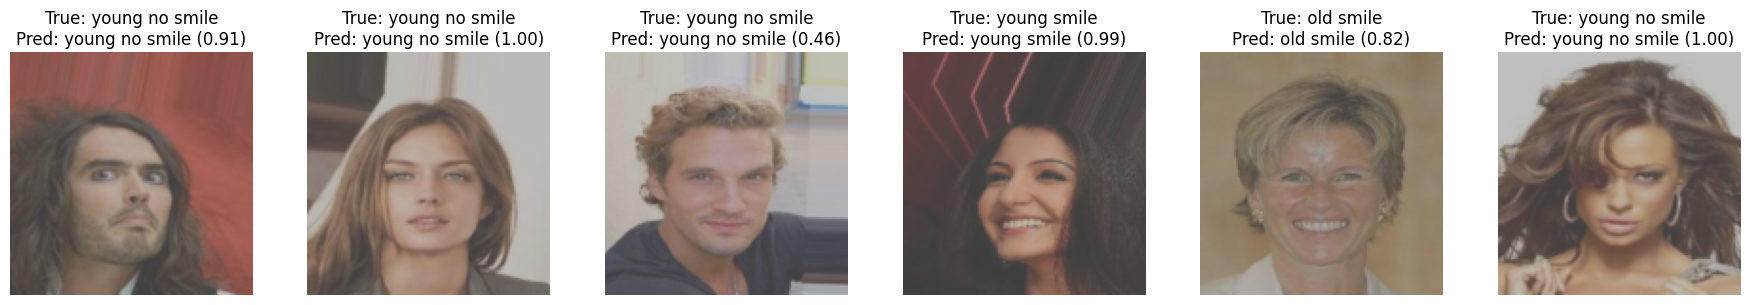

In [15]:

# Show a few sample predictions from the trained CNN on the test set
cnn.eval()

# number of samples to display
n_samples = 6

# get one batch from test loader
batch = next(iter(test_dl))
imgs_batch, labels_batch = batch
imgs = imgs_batch[:n_samples]
labels = labels_batch[:n_samples]

# forward pass
with torch.no_grad():
    imgs_device = imgs.to(device)
    outputs = cnn(imgs_device)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1).cpu()

# plot samples with true / predicted labels and probabilities
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 3, 3))
if n_samples == 1:
    axes = [axes]

for i in range(n_samples):
    img = imgs[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # unnormalize
    img = img.clip(0, 1)

    true_lbl = int(labels[i].item())
    pred_lbl = int(preds[i].item())
    pred_prob = float(probs[i, pred_lbl].cpu().item())

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {class_map[true_lbl]}\nPred: {class_map[pred_lbl]} ({pred_prob:.2f})")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [16]:
from pytorch_msssim import ssim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def SSIMLoss(x, y):
    return 1 - ssim(x, y, data_range=2.0)


class SobelLoss(nn.Module):
    def __init__(self):
        super().__init__()

        sobel_x = torch.tensor([
            [-1., 0., 1.],
            [-2., 0., 2.],
            [-1., 0., 1.]
        ]).repeat(3, 1, 1, 1)  # -> shape (3,1,3,3)

        sobel_y = torch.tensor([
            [-1., -2., -1.],
            [ 0.,  0.,  0.],
            [ 1.,  2.,  1.]
        ]).repeat(3, 1, 1, 1)

        self.sobel_x = nn.Parameter(sobel_x, requires_grad=False)
        self.sobel_y = nn.Parameter(sobel_y, requires_grad=False)

    def forward(self, img, target):
        # img, target: [B,3,H,W]
        gx_img = F.conv2d(img, self.sobel_x, padding=1, groups=3)
        gy_img = F.conv2d(img, self.sobel_y, padding=1, groups=3)

        gx_target = F.conv2d(target, self.sobel_x, padding=1, groups=3)
        gy_target = F.conv2d(target, self.sobel_y, padding=1, groups=3)

        return F.l1_loss(gx_img, gx_target) + F.l1_loss(gy_img, gy_target)


class VGGPerceptualLoss(nn.Module):
  def __init__(self):
      super().__init__()
      vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
      self.vgg_features = nn.Sequential(*list(vgg.features.children())[:16]).eval()
      for param in self.vgg_features.parameters():
          param.requires_grad = False

      self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
      self.register_buffer("std",  torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

  def forward(self, input_img, target_img):
      # convert 1-channel (CelebA aligned grayscale?) to 3-channel
      if input_img.shape[1] == 1:
          input_img = input_img.repeat(1, 3, 1, 1)
          target_img = target_img.repeat(1, 3, 1, 1)

      # [-1,1] → [0,1]
      input_img  = (input_img  + 1) / 2
      target_img = (target_img + 1) / 2

      # normalize for VGG
      input_img  = (input_img  - self.mean) / self.std
      target_img = (target_img - self.mean) / self.std

      return nn.functional.mse_loss(
          self.vgg_features(input_img),
          self.vgg_features(target_img)
      )


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms as T
from tqdm import tqdm
import math

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3)   # images mapped to [-1, 1]
])
print(f"Length of training dataset: {len(train_ds)}")

train_dl = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder(latent_dim=128).to(device)


criterion_mse = nn.MSELoss()
criterion_vgg = VGGPerceptualLoss().to(device)
sobel_loss = SobelLoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
state_dict = torch.load("autoencoder_celeba_best.pth", map_location=device)
autoencoder.load_state_dict(state_dict)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

total_steps = 350_000
epochs = math.ceil(total_steps / len(train_dl))

print(f"Training for {epochs} epochs to reach {total_steps} steps\n")

# ---- early stopping settings ----
patience = 8
min_delta = 1e-4
best_val_loss = float("inf")
early_stop_counter = 0

step = 0
autoencoder.train()

for epoch in range(epochs):
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}")
    epoch_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        recon = autoencoder(images)
        loss_mse = criterion_mse(recon, images)
        loss_ssim = SSIMLoss(recon, images)
        loss_vgg = criterion_vgg(recon, images)
        loss_grad = sobel_loss(recon, images)

        loss = (
            0.5 * loss_mse +
            0.3 * loss_ssim +
            0.1 * loss_vgg +
            0.1 * loss_grad
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step += 1
        epoch_loss += loss.item()

        pbar.set_postfix({"step": step, "loss": loss.item()})

        if step >= total_steps:
            break


    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in val_dl:
            images = images.to(device)
            recon = autoencoder(images)
            loss_mse = criterion_mse(recon, images)
            loss_ssim = SSIMLoss(recon, images)
            loss_vgg = criterion_vgg(recon, images)
            loss_grad = sobel_loss(recon, images)

            loss = (
            0.5 * loss_mse +
            0.3 * loss_ssim +
            0.1 * loss_vgg +
            0.1 * loss_grad
        )
            val_loss += loss.item()

    val_loss /= len(val_dl)
    print(f"Validation loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    autoencoder.train()

    #     EARLY STOPPING
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(autoencoder.state_dict(), "autoencoder_celeba_best.pth")
        print("⬇️ New best model saved.")
    else:
        early_stop_counter += 1
        print(f"⚠️ Plateau detected ({early_stop_counter}/{patience})")

    if early_stop_counter >= patience:
        print("⛔ Early stopping triggered due to plateau.")
        break

    if step >= total_steps:
        break

print("\nTraining complete!")
ae_model_path = "models/torch_ae_celeba_trained.pth"
torch.save(autoencoder.state_dict(), ae_model_path)
print(f"Model saved to {ae_model_path}")


Length of training dataset: 164105
Training for 273 epochs to reach 350000 steps

Learning Rate: 0.000100


Epoch 1/273:   1%|          | 10/1283 [00:05<10:47,  1.97it/s, step=10, loss=0.601]


KeyboardInterrupt: 

In [18]:
autoencoder = Autoencoder(latent_dim=128).to(device)
state_dict = torch.load("autoencoder_celeba_best.pth", map_location=device)
autoencoder.load_state_dict(state_dict)


<All keys matched successfully>

### CFS generating

In [46]:
from sklearn.preprocessing import FunctionTransformer


device = "cuda" if torch.cuda.is_available() else "cpu"

autoencoder = Autoencoder(latent_dim=128).to(device)
state_dict = torch.load("models/torch_ae_celeba_trained.pth", map_location=device)
autoencoder.load_state_dict(state_dict)

# encode first 10 test images into latent space and build latent_dataset
n_samples = 10

batch = next(iter(test_dl))
images_batch, labels_batch = batch
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

identity = FunctionTransformer(lambda x: x.to_numpy(), validate=False)

latent_dataset = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)

print(f"Created latent_dataset with {len(data_df)} samples and {latent_dim_actual} latent dims")


Created latent_dataset with 10 samples and 128 latent dims


In [47]:
latent_dataset.df.head(10)


,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l118,l119,l120,l121,l122,l123,l124,l125,l126,l127
0,-0.164145,0.146650,0.068478,-0.254583,0.170094,0.309364,0.106538,0.174273,-0.132509,-0.365697,...,0.075762,0.006095,-0.088461,-0.002690,0.159954,0.229565,0.153376,0.028254,0.213825,0.117936
1,0.242545,0.376176,0.171781,0.042205,-0.100184,0.060500,-0.093710,0.158211,-0.309745,-0.393697,...,-0.039170,-0.055645,-0.223921,-0.317591,0.310576,0.141324,-0.122569,-0.150920,-0.175277,-0.078603
2,-0.279985,0.246156,0.194191,0.075148,0.342002,-0.177597,-0.162800,0.249037,0.088208,0.208432,...,-0.344812,-0.382891,-0.057936,-0.318335,-0.181982,-0.016629,-0.095995,0.169011,0.225791,0.173276
3,-0.026069,-0.327820,0.103741,0.122075,0.138546,-0.097473,-0.012668,-0.083994,0.091159,-0.078242,...,0.017757,-0.104340,0.190139,0.198724,0.180255,-0.105389,0.152380,-0.014135,-0.359128,0.206564
4,-0.110769,0.032315,-0.181575,0.002718,0.260773,0.033471,-0.251846,0.071503,-0.065616,0.179966,...,0.012377,-0.129963,0.141582,-0.072721,-0.163654,0.075354,-0.207168,-0.051074,-0.041783,-0.011705
5,-0.067403,-0.320485,0.066412,-0.006681,0.208523,0.064975,-0.109485,-0.171112,0.215766,-0.024318,...,-0.121280,-0.407292,0.183788,0.250774,0.025074,-0.331029,0.058616,0.046059,-0.236674,-0.051476
6,0.159121,-0.018966,-0.053091,0.017690,-0.030034,-0.151439,-0.267165,0.079400,0.142338,-0.077861,...,-0.111306,0.006516,0.007673,-0.337022,0.132081,0.202517,-0.368133,-0.113871,0.263543,-0.048839
7,0.069686,-0.061345,0.014889,0.096413,-0.097699,-0.299171,-0.117490,-0.054886,0.117175,0.012950,...,0.353490,0.233807,-0.046216,0.421773,0.175192,-0.091045,0.048968,0.184079,-0.207075,0.001255
8,0.359185,-0.139139,-0.415829,0.001321,-0.245819,-0.101809,0.056281,-0.018081,0.015007,-0.114107,...,0.002576,0.247182,-0.357250,0.075942,0.084996,0.109821,-0.146914,-0.105724,-0.168220,0.042334
9,-0.054362,0.052555,-0.224830,0.287031,0.326078,-0.285528,-0.216412,-0.100729,0.169241,-0.227093,...,-0.083802,-0.165581,-0.156822,-0.216154,-0.346464,-0.020179,-0.062730,-0.153059,-0.210299,-0.231804


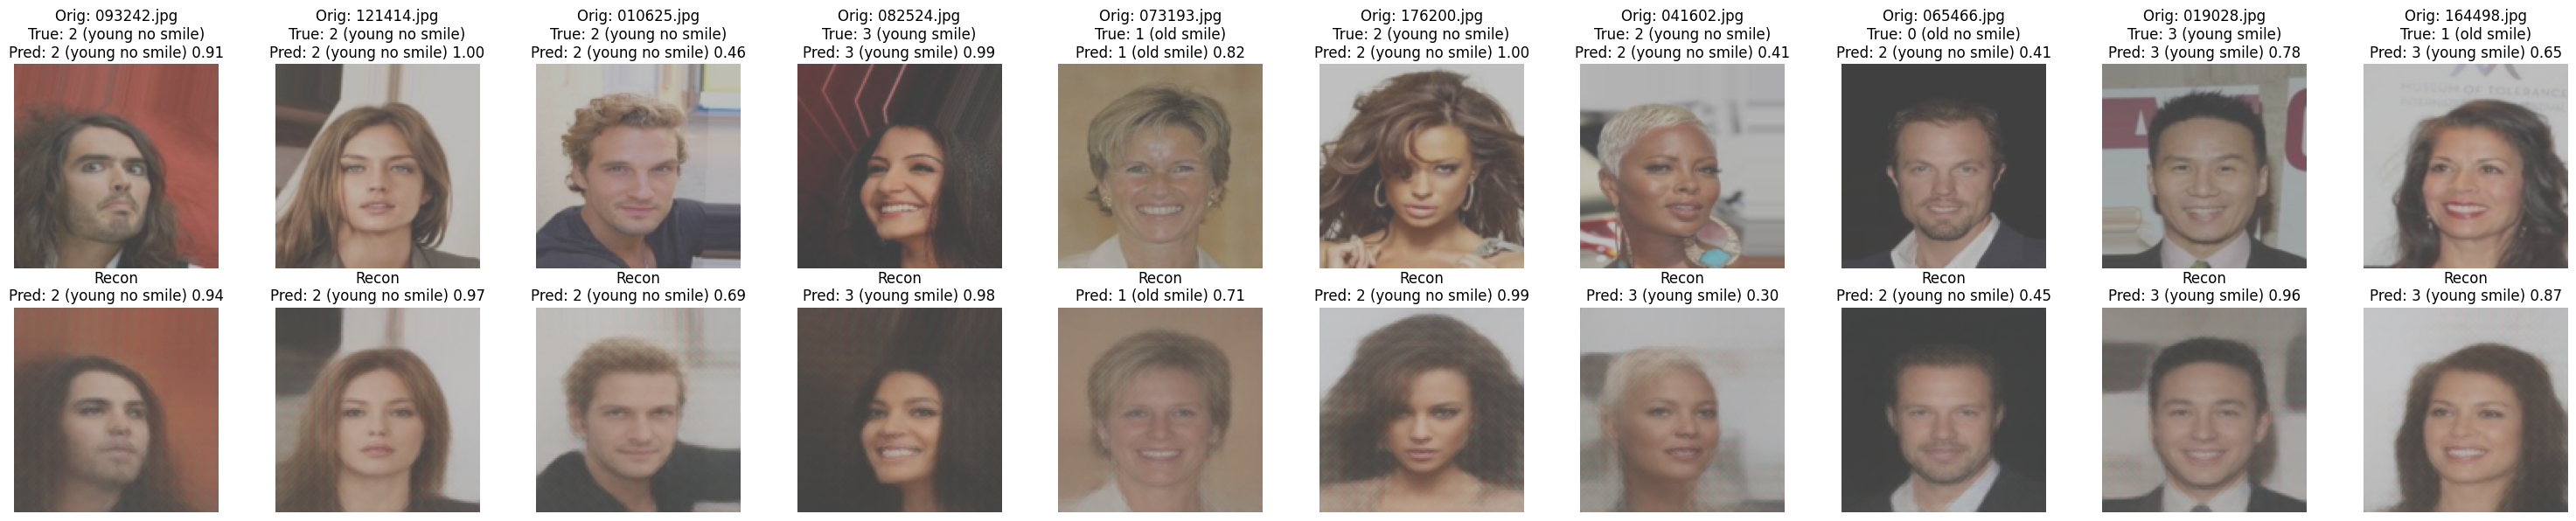

In [48]:
# Add reconstruction with autoencoder (if not already present) and plot originals/reconstructions + CNN preds
cnn = CNN().to(device)
state_dict = torch.load("models/torch_cnn_celeba_paper.pth", map_location=device)
cnn.load_state_dict(state_dict)


cnn.eval()
autoencoder.eval()

# ensure imgs on device for model calls
imgs_device = imgs.to(device)

with torch.no_grad():
    outputs_orig = cnn(imgs_device)
    probs_orig = torch.softmax(outputs_orig, dim=1)
    preds_orig = torch.argmax(probs_orig, dim=1).cpu().tolist()
    top_probs_orig = probs_orig.max(dim=1)[0].cpu().tolist()

# compute reconstructions with AE if missing or wrong size
if not ('recons' in globals() and isinstance(recons, torch.Tensor) and recons.size(0) == imgs.size(0)):
    with torch.no_grad():
        recons = autoencoder(imgs_device)

have_recon = isinstance(recons, torch.Tensor) and recons.size(0) == imgs.size(0)
if have_recon:
    with torch.no_grad():
        outputs_recon = cnn(recons)
        probs_recon = torch.softmax(outputs_recon, dim=1)
        preds_recon = torch.argmax(probs_recon, dim=1).cpu().tolist()
        top_probs_recon = probs_recon.max(dim=1)[0].cpu().tolist()

# DataLoader used shuffle=False so the first batch corresponds to the first rows of test_ds.df
n = imgs.size(0)
image_ids = test_ds.df.iloc[:n]['image_id'].tolist()

# prepare numpy images for display (unnormalize from [-1,1] to [0,1])
orig_np = imgs.cpu().permute(0, 2, 3, 1).numpy()
orig_np = (orig_np * 0.5) + 0.5
orig_np = orig_np.clip(0, 1)

if have_recon:
    recon_np = recons.cpu().permute(0, 2, 3, 1).numpy()
    recon_np = (recon_np * 0.5) + 0.5
    recon_np = recon_np.clip(0, 1)

import matplotlib.pyplot as plt

if have_recon:
    fig, axes = plt.subplots(2, n, figsize=(n * 3, 6))
    if n == 1:
        axes = axes.reshape(2, 1)
    for i in range(n):
        axes[0, i].imshow(orig_np[i], cmap='gray')
        axes[0, i].set_title(f"Orig: {image_ids[i]}\nTrue: {targets[i]} ({class_map[targets[i]]})\nPred: {preds_orig[i]} ({class_map[preds_orig[i]]}) {top_probs_orig[i]:.2f}")
        axes[0, i].axis("off")

        axes[1, i].imshow(recon_np[i], cmap='gray')
        axes[1, i].set_title(f"Recon\nPred: {preds_recon[i]} ({class_map[preds_recon[i]]}) {top_probs_recon[i]:.2f}")
        axes[1, i].axis("off")
else:
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    if n == 1:
        axes = [axes]
    for i in range(n):
        axes[i].imshow(orig_np[i], cmap='gray')
        axes[i].set_title(f"{image_ids[i]}\nTrue: {targets[i]} ({class_map[targets[i]]})\nPred: {preds_orig[i]} ({class_map[preds_orig[i]]}) {top_probs_orig[i]:.2f}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


In [49]:
latent_wrapper = BatchedLatentWrapper(autoencoder.decoder, cnn, device)
explainer = GrowingSpheresExplainer(step_size=0.001, num_samples=10, max_radius=2)
counterfactuals = explainer.explain(latent_wrapper, latent_dataset)


0instance [00:10, ?instance/s]


KeyboardInterrupt: 

In [ ]:
counterfactuals


[Counterfactual(original_data=array([-1.64145336e-01,  1.46650299e-01,  6.84778094e-02, -2.54582852e-01,
         1.70094177e-01,  3.09364259e-01,  1.06537648e-01,  1.74272701e-01,
        -1.32508829e-01, -3.65697473e-01,  1.13193326e-01,  1.06202878e-01,
        -2.30146646e-02, -1.75850652e-03, -1.43058017e-01, -5.27803972e-02,
         5.59927188e-02, -1.47790343e-01, -1.58320710e-01,  3.24054994e-02,
         2.42864415e-01,  1.63660213e-01, -1.75113931e-01, -2.96944678e-01,
         1.53254375e-01,  7.86202475e-02,  1.40395164e-01,  1.45182967e-01,
         1.06317326e-01,  1.41326934e-01, -3.28384161e-01,  1.82009056e-01,
         1.84779078e-01,  9.82079133e-02,  6.01870157e-02, -6.64214492e-02,
        -2.57777333e-01, -4.28707413e-02, -1.54943794e-01,  7.78698921e-02,
        -3.41763884e-01,  1.27918169e-01,  2.25066662e-01, -1.34935379e-01,
         6.35064989e-02,  4.20898139e-01, -2.20770314e-02,  1.17551973e-02,
         4.75239269e-02,  4.41151895e-02, -1.01509150e-02, 

IndexError: list index out of range

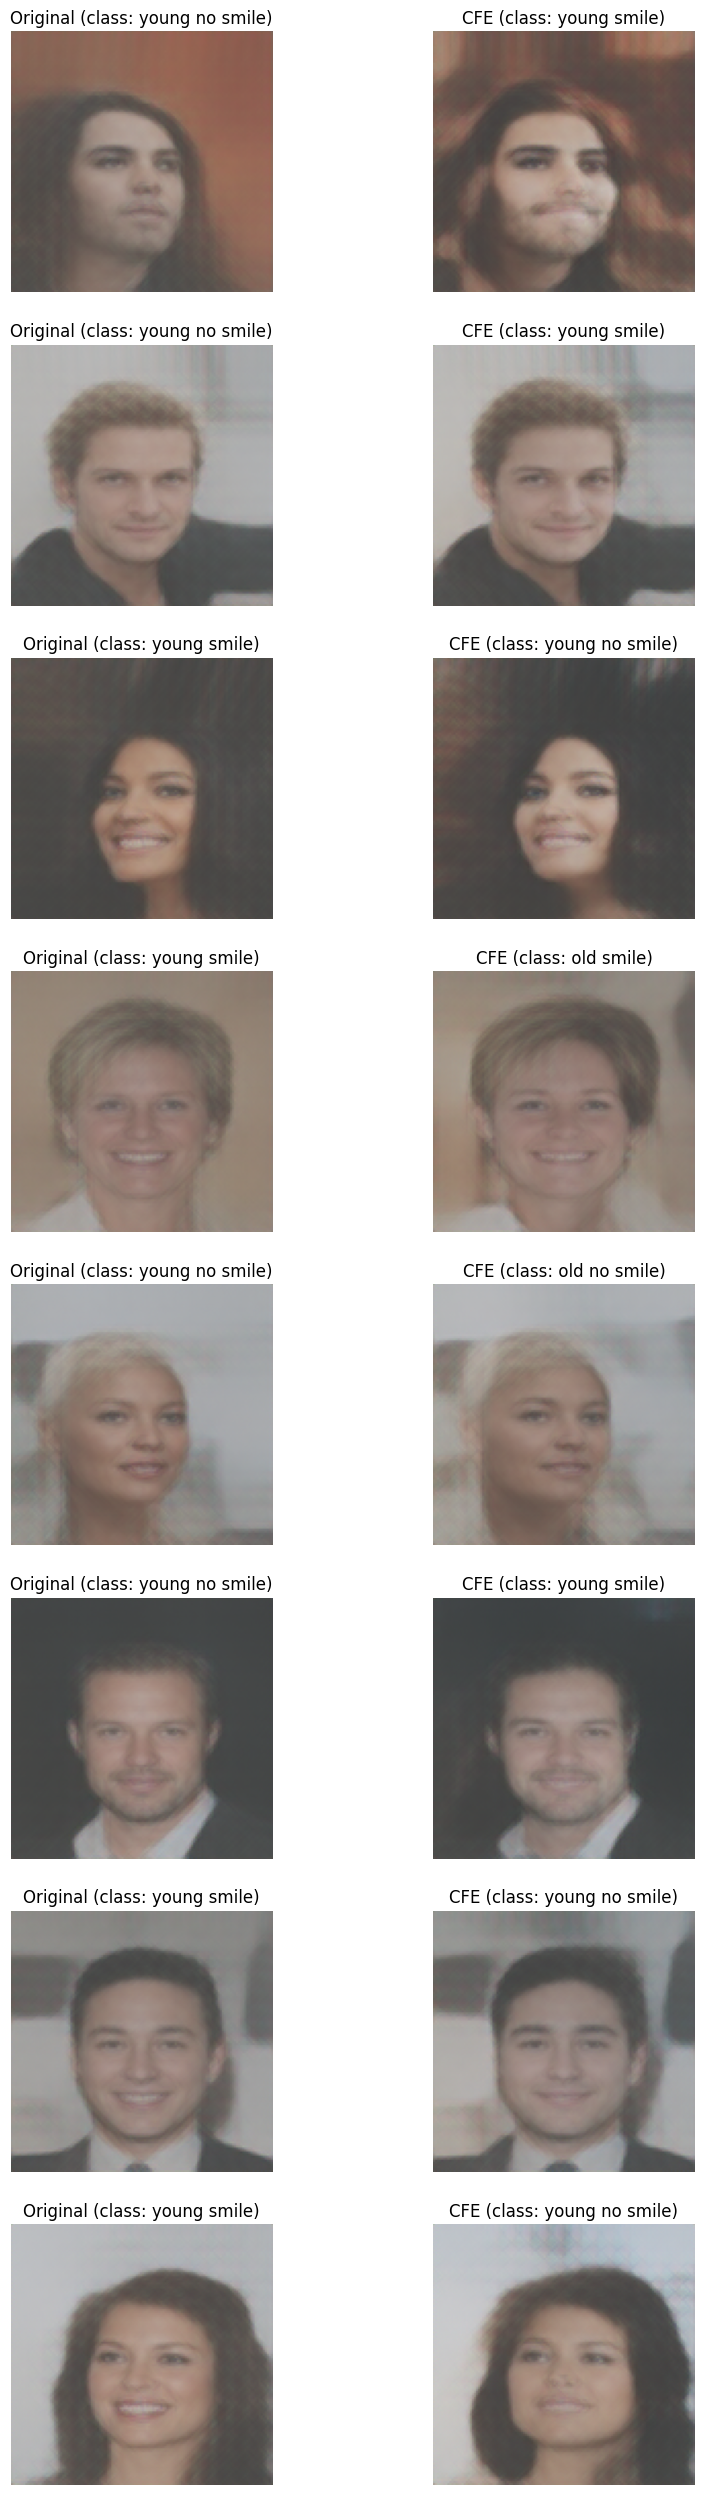

In [ ]:
plt.figure(figsize=(10, 4 * n))

for i in range(n):
    cf = counterfactuals[i]

    # ---- ORIGINAL RECONSTRUCTION ----
    org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
    org_recon = autoencoder.decoder(org_latent)      # shape [1, 3, 128, 128]

    org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]

    # map from [-1, 1] → [0, 1]
    org_recon_np = (org_recon_np + 1) / 2
    org_recon_np = org_recon_np.clip(0, 1)

    # ---- COUNTERFACTUAL RECONSTRUCTION ----
    cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
    cfe_recon = autoencoder.decoder(cf_latent)

    cfe_recon_np = cfe_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
    cfe_recon_np = (cfe_recon_np + 1) / 2
    cfe_recon_np = cfe_recon_np.clip(0, 1)

    # ---- PLOTTING ----
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(org_recon_np)
    plt.title(f"Original (class: {class_map[cf.original_class]})")
    plt.axis("off")

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(cfe_recon_np)
    plt.title(f"CFE (class: {class_map[cf.target_class]})")
    plt.axis("off")

plt.tight_layout()
